# Three-Layer NN - MNIST

The process will be broken down into the following steps:

1. Load the data
2. Define the network's architecture
3. Train the model
4. Evaluate the performance of the trained model on a test dataset!

The key idea in this notebook is to use __validation set__ to monitor the generalization power of the learning algorithm; the final model will be selected based on how well it performs on the validation set, and not necessarily the model trained at the very last epoch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch

import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torchvision import datasets
from torchvision.transforms import transforms

In [4]:
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
transform = transforms.ToTensor()

In [6]:
# Number of subprocesses to use for data loading
# Set to zero, if no parallelization required.
n_workers = 0

# Number of samples to load per batch
batch_size = 32

# Percentage of  the training data to be used as validation set
valid_size = .2

In [7]:
# Select the training and test dataset
data_train = datasets.MNIST(root= 'data', train= True, download= True, transform= transform)
data_test = datasets.MNIST(root= 'data', train= False, download= True, transform= transform)

In [8]:
# Select training samples that are used for validation

num_train = len(data_train)
indices = list(range(num_train))

np.random.shuffle(indices)
ix2split = int(valid_size * num_train)

ix_valid, ix_train = indices[:ix2split], indices[ix2split:]
len(ix_valid), len(ix_train)

(12000, 48000)

In [9]:
# Define samplers for obtaining training and validation batches
sampler_train = SubsetRandomSampler(ix_train)
sampler_valid = SubsetRandomSampler(ix_valid)

loader_train = torch.utils.data.DataLoader(data_train, batch_size= batch_size,
                                           sampler= sampler_train, num_workers= n_workers)

loader_valid = torch.utils.data.DataLoader(data_train, batch_size= batch_size,
                                           sampler= sampler_valid, num_workers= n_workers)

loader_test = torch.utils.data.DataLoader(data_test, batch_size= batch_size, num_workers= n_workers)

## Define the Network Architecture

In [10]:
class Net(nn.Module):
    """Three layer NN for detecting MNIST digits."""
    
    def __init__(self):
        super(Net, self).__init__()
        # Set the number of nodes in 
        hidden1 = 512
        hidden2 = 512

        # Input is a 28 x 28 gray-scale image:
        self.fc1 = nn.Linear(28 * 28, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 10) # output has 10 classes
        # Kill 20% of the nodes in hidden units when training
        self.dropout = nn.Dropout(.2)
        
    def forward(self, x):
        """Run the Forward Pass."""
        # Flatten the input image
        x = x.view(-1, 28 * 28)
        # First hidden layer
        x = F.relu(self.fc1(x))
        # Second hidden layer
        x = F.relu(self.fc2(x))
        # Output layer
        # No need to apply activation function here
        # Because our choice of loss function - categorical cross-entropy
        ##will also perform the log-softmax before applying NLLL
        x = self.fc3(x)

        return x

In [11]:
# Initialize the model
model = Net()

# Print out the model to check the configuration
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


## Specify Loss Function and Optimizer

It's recommended to use __cross-entropy loss__ for __classification tasks__.   

Note: PyTorch's cross entropy function first applies a softmax funtion to the output layer and then calculates the log loss.

In [12]:
# Specify the loss function
criterion = nn.CrossEntropyLoss()

# Specify the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = .03)

## Train the Network

The typical steps for training/learning from a batch of data is as follows:

1. Clear the gradients of all optimized variables
2. Forward pass: make the prediction for a specific input
3. Calculate the loss: how off is the prediction compared to the truth
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Update the parameters: perform a single optimization step
6. Update average training loss

In [13]:
n_epochs = 40

# Initialize tracker for validation loss
# The idea is to have an "early stopping" strategy
# That is, when the validation set loss starts to increase
# It is a sign that our network starts to overfit
# Ergo, we stop training further. Because we are interested
# in generalization power of our algorithm.

loss_valid_min = np.Inf 

In [14]:
training_loss = []
validation_loss = []

for e in range(n_epochs):
    loss_train = 0
    loss_valid = 0
    
    # training phase =============================
    # Prep the model for training phase
    model.train()
    for data, target in loader_train:
        # Run the workflow for a batch of training -- 6 steps specified above:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        
        loss_train += loss.item() * data.size(0)
        
    # validation phase ===========================
    # Prep the model for evaluation phase.
    # this for example, deactivates the dropout layer.
    model.eval()
    
    for data, target in loader_valid:
        out = model(data)
        loss = criterion(out, target)
        loss_valid += loss.item() * data.size(0)
        
    # Calculate average loss over an epoch
    loss_train = loss_train / len(loader_train.sampler)
    loss_valid = loss_valid / len(loader_valid.sampler)
    
    training_loss.append(loss_train)
    validation_loss.append(loss_valid)
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e + 1, loss_train, loss_valid))
    
    # save model if validation loss has decreased
    if loss_valid < loss_valid_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).'.format(
        loss_valid_min,  loss_valid))
        print('Saving model...\n')
        torch.save(model.state_dict(), 'model.pt')
        loss_valid_min = loss_valid


Epoch: 1 	Training Loss: 0.641604 	Validation Loss: 0.293212
Validation loss decreased (inf --> 0.293212).
Saving model...

Epoch: 2 	Training Loss: 0.259329 	Validation Loss: 0.213821
Validation loss decreased (0.293212 --> 0.213821).
Saving model...

Epoch: 3 	Training Loss: 0.191226 	Validation Loss: 0.170277
Validation loss decreased (0.213821 --> 0.170277).
Saving model...

Epoch: 4 	Training Loss: 0.148951 	Validation Loss: 0.144030
Validation loss decreased (0.170277 --> 0.144030).
Saving model...

Epoch: 5 	Training Loss: 0.120475 	Validation Loss: 0.121367
Validation loss decreased (0.144030 --> 0.121367).
Saving model...

Epoch: 6 	Training Loss: 0.099822 	Validation Loss: 0.110515
Validation loss decreased (0.121367 --> 0.110515).
Saving model...

Epoch: 7 	Training Loss: 0.084187 	Validation Loss: 0.096659
Validation loss decreased (0.110515 --> 0.096659).
Saving model...

Epoch: 8 	Training Loss: 0.071689 	Validation Loss: 0.089653
Validation loss decreased (0.096659 --> 0

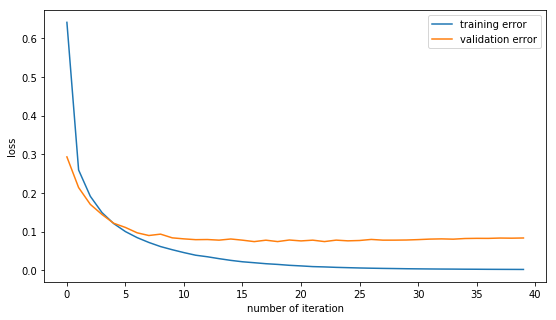

In [15]:
plt.figure(figsize= (9, 5))
plt.plot(training_loss, label= 'training error')
plt.plot(validation_loss, label= 'validation error')
plt.xlabel('number of iteration')
plt.ylabel('loss')
plt.legend()

As you see, _epoch 17_ is where the __validation loss__ is at minimum. All the other iterations after that, do not help the generalization power of this particular network. As a result, we can simply use the model at that iteration, which we've saved.

### Load the Model with the Lowest Validation Loss

In [16]:
model.load_state_dict(torch.load('model.pt'))

## Test the Trained Network

In [17]:
# initialize lists to monitor test loss and accuracy
loss_test = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# prep model for evaluation
model.eval()

for data, target in loader_test:
    # forward pass: compute predicted outputs by passing inputs to the model
    out = model(data)
    loss = criterion(out, target)
    # update test loss 
    loss_test += loss.item() * data.size(0)
    
    # convert output probabilities to predicted class
    _, pred = torch.max(out, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    
    # calculate test accuracy for each object class
    # Note that not enough samples may be left for the last batch
    # Specifically: len(data_test) % 32 => 16
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

In [18]:
# calculate and print avg test loss
loss_test = loss_test / len(loader_test.dataset)
print('Test Loss: {:.6f}\n'.format(loss_test))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.070145


Test Accuracy (Overall): 97% (9788/10000)


In [19]:
# calculate the accuracy for each class
acc = [round(match/total, 2) for match, total in zip(class_correct, class_total)]

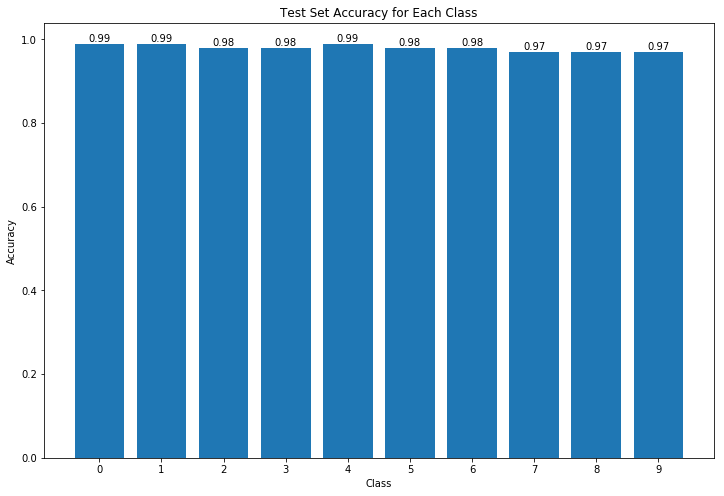

In [20]:
plt.figure(figsize= (12, 8))
labels = list(range(len(acc)))
line = plt.bar(labels, acc)
plt.xticks(labels)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Test Set Accuracy for Each Class')

for i in range(len(acc)):
    plt.annotate(str(acc[i]), xy=(labels[i], acc[i]), ha='center', va='bottom')

## Visualize Sample Test Results

''

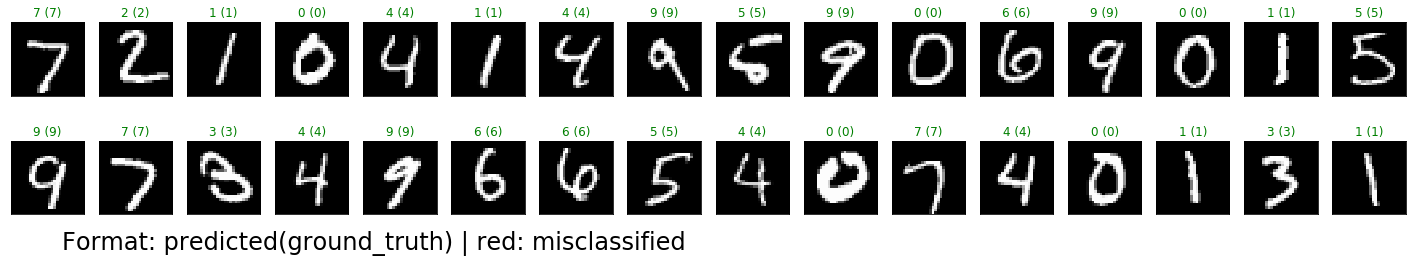

In [21]:
# obtain one batch of test images
dataiter = iter(loader_test)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))

num_samples = len(labels)
num_rows = 2
for ix in range(num_samples):
    ax = fig.add_subplot(num_rows, num_samples / num_rows, ix+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[ix]), cmap='gray')
    ax.set_title('{} ({})'.format(str(preds[ix].item()), str(labels[ix].item())),
                 color=('green' if preds[ix]==labels[ix] else 'red'))

fig.text(.5, .05, 'Format: predicted(ground_truth) | red: misclassified',
         ha='right', fontsize= 24)
;